In [ ]:
import os
import sys

if 'google.colab' in sys.modules:       # Si on est dans Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/internship_cvut'
else:
    # Exécution locale : on se base sur le chemin du fichier
    project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))

# Changer le dossier courant vers le dossier du projet
os.chdir(project_path)

# Ajouter src/ au path si nécessaire
src_path = os.path.join(project_path, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Optionnel : vérifier que tout est bien configuré
# print("Répertoire courant :", os.getcwd())
# print("Contenu de src :", os.listdir(src_path))
# print("Contenu de database :", os.listdir(os.path.join(project_path, 'database')))

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

from python_scripts.miscellaneaous.data_processing import extract_data
from python_scripts.road_detection.road_utils import *

### Fonctionnement


Pour chaque point, on essaie de tracer une "ligne" en avançant pas à pas, en partant dans la direction du voisin le plus proche

À chaque étape, on cherche le voisin le plus proche dans la même direction, jusqu'à ce qu'on ne trouve pas de voisin assez proche et aligné.

On récupère des courbes souples

### Méthode de base

/tmp/ipython-input-4-3923002840.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


6186 chaînes détectées


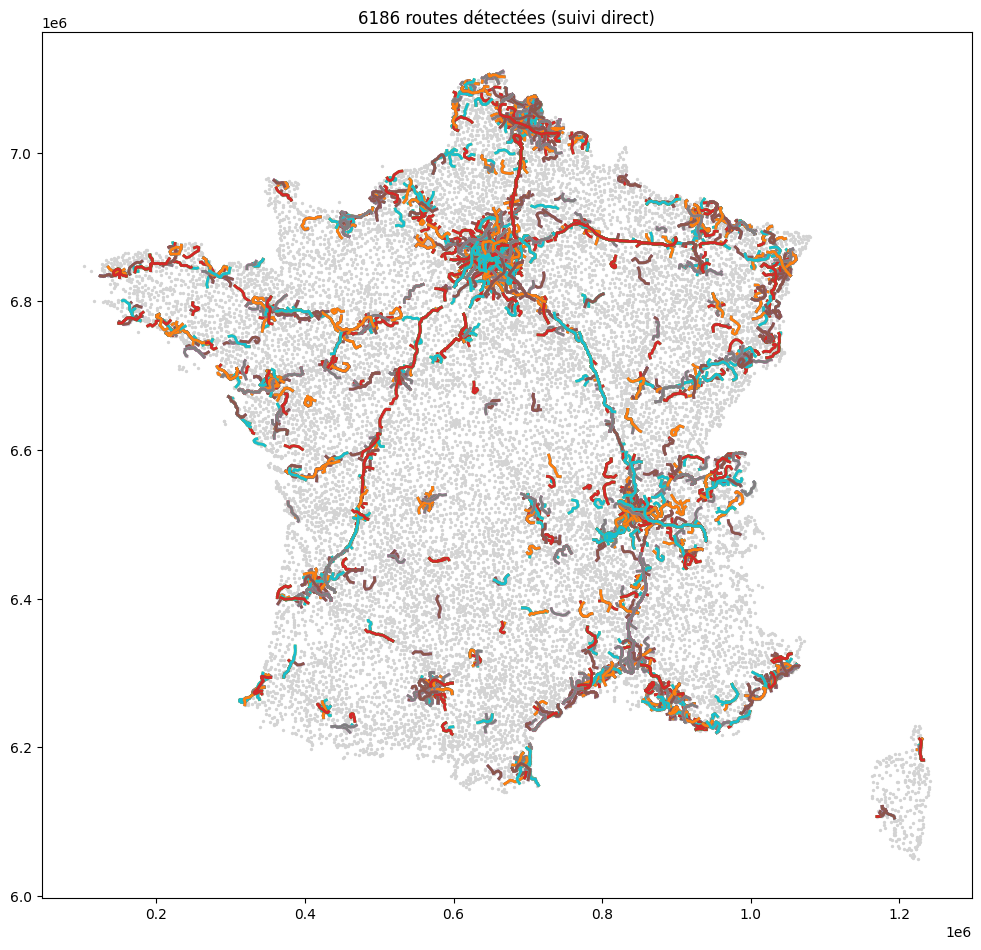

Longueur détectée : 350198.6 km
Longueur réelle (référence) : 432680.0 km
Erreur absolue : 82481.4 km
Erreur relative : 19.06%


(np.float64(82481.44610073825), np.float64(0.19062920888587004))

In [ ]:
# Données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider="Orange") #, techno="5G") #, region='Normandie', techno="4G")
xy = df[['x', 'y']].to_numpy()

# Paramètres
k = 10                       # Nombre de voisins max à examiner
angle_max = 80               # Tolérance d'orientation entre étapes (en degrés)
dist_max = 4500 #4500              # Distance max pour étendre la chaîne
min_chain_len = 10           # Longueur min pour considérer une "route"


# Étape 1 : construire un index pour les voisins
nn = NearestNeighbors(n_neighbors=k+1).fit(xy)
_, indices = nn.kneighbors(xy)

used = set()
chains = []

# Étape 2 : suivre des lignes à partir de chaque point
for i in range(len(xy)):
    if i in used:
        continue

    # On initialise la chaîne dans les deux directions
    for direction in [+1, -1]:
        chain = [i]
        current = i
        prev_vec = None

        while True:
            candidates = indices[current][1:]  # sans lui-même
            best = None
            best_angle = angle_max
            for j in candidates:
                if j in chain:
                    continue
                vec = xy[j] - xy[current]
                dist = np.linalg.norm(vec)
                if dist > dist_max:
                    continue
                if prev_vec is None:
                    angle = 0
                else:
                    angle = angle_between(prev_vec, vec)
                if angle < best_angle:
                    best_angle = angle
                    best = j

            if best is None:
                break
            chain.append(best)
            prev_vec = xy[best] - xy[current]
            current = best

        if len(chain) >= min_chain_len:
            chains.append(chain)
            used.update(chain)

print(f"{len(chains)} chaînes détectées")

# Affichage
affichage_chains(xy, chains, title = f"{len(chains)} routes détectées (suivi direct)")

# Erreur
evaluate_chain_detection(xy, chains)

# # Erreur par dép
# df_eval = evaluate_by_department(xy, chains, df['nom_dep'])
# print(df_eval.head(10))  # top 10 pires départements

# # Barplot
# df_eval_sorted = df_eval.sort_values(by="Erreur relative", ascending=False)

# plt.figure(figsize=(16, 6))
# plt.bar(df_eval_sorted["Département"], df_eval_sorted["Erreur (km)"])
# plt.xticks(rotation=90)
# plt.title("Erreur absolue par département (km)")
# plt.tight_layout()
# plt.show()

### Amélioration 1

Pars dans plusieurs directions (suffisamment différentes) à partir d'une station, en considérant à chaque étape un nombre limite de voisins.

/tmp/ipython-input-978422361.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


Nombre total de chaînes : 17715


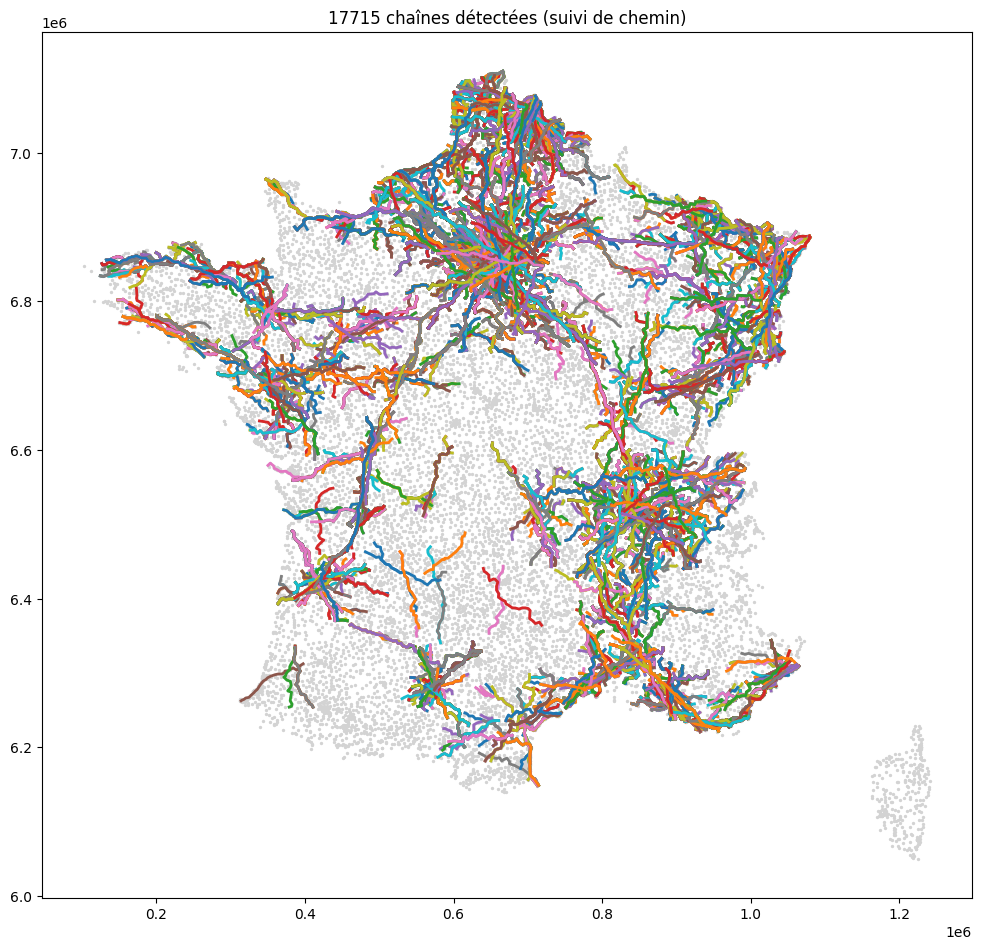

🔹 Nombre de chaînes trouvées :  17715
🔹 Longueur moyenne des chaînes : 122.100 km
🔹 Écart-type longueur des chaînes : 53.309 km
🔹 Longueur moyenne des chaînes : 41.0 stations
🔹 Écart-type longueur des chaînes : 15.59

🔹 Évaluation globale :
Longueur détectée : 2163003.4 km
Longueur réelle (référence) : 432680.0 km
Erreur absolue : 1730323.4 km
Erreur relative : 399.91%

🔹 Évaluation par département :
          Département  Réel (km)  Détecté (km)  Erreur (km)  \
9               Paris         73       27874.9      27801.9   
30            Essonne        365      100103.7      99738.7   
66         Val-d'Oise        333       85420.1      85087.1   
37           Yvelines        586      120918.7     120332.7   
90  Seine-Saint-Denis        178       34508.1      34330.1   

   Erreur relative (%)  
9             38084.9%  
30            27325.7%  
66            25551.7%  
37            20534.6%  
90            19286.6%  

Écart-type des erreurs départementales : 66.919
Max erreur relativ

In [ ]:
# Données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider="Orange") #, techno="5G") #, region='Normandie', techno="4G")
xy = df[['x', 'y']].to_numpy()
departements = df['nom_dep']

# ref_total_length = 980 + 342  # Autoroutes + Nationales centre val de loire, d'après l'observatoire des territoires   #df_routes['Autoroutes'].sum() + df_routes['Routes nationales'].sum() + df_chemin_fer['long_ferre'].sum()

ref_total_length = (
    df_routes['Autoroutes'].sum() +
    df_routes['Routes nationales'].sum() +
    # df_routes['Routes départementales et voies communales'].sum() +
    382491 +    # Routes départementales, d'après statista
    # 714883 +  # Routes communales, d'après statista
    df_chemin_fer['long_ferre'].sum()
)

# Paramètres
n_neighbors = 15             # Nombre de voisins max à examiner
n_directions = 4             # Nombre de directions à tester
angle_tol = 4                # Angle min entre directions de départ
angle_max = 80               # Tolérance d'orientation entre étapes (en degrés)
dist_max = 6000              # Distance max pour étendre la chaîne
min_len = 25                 # Longueur min pour considérer une "route"

# Application
chains = detect_chains_by_follow_line(xy, n_neighbors, n_directions, angle_tol, dist_max, angle_max, min_len)

affichage_chains(xy, chains, title = f"{len(chains)} chaînes détectées (suivi de chemin)")

# Erreur
# evaluate_chain_detection(xy, chains, departements, ref_total_length)
df_metrics = compute_chain_metrics(xy, chains, departements, ref_total_length)

### Amélioration 2

Fusionner les chaînes obtenues si leurs extrémités sont suffisamment proches et qu'elles sont globalement dans la même direction.

6186 → 5779 chaînes après fusion


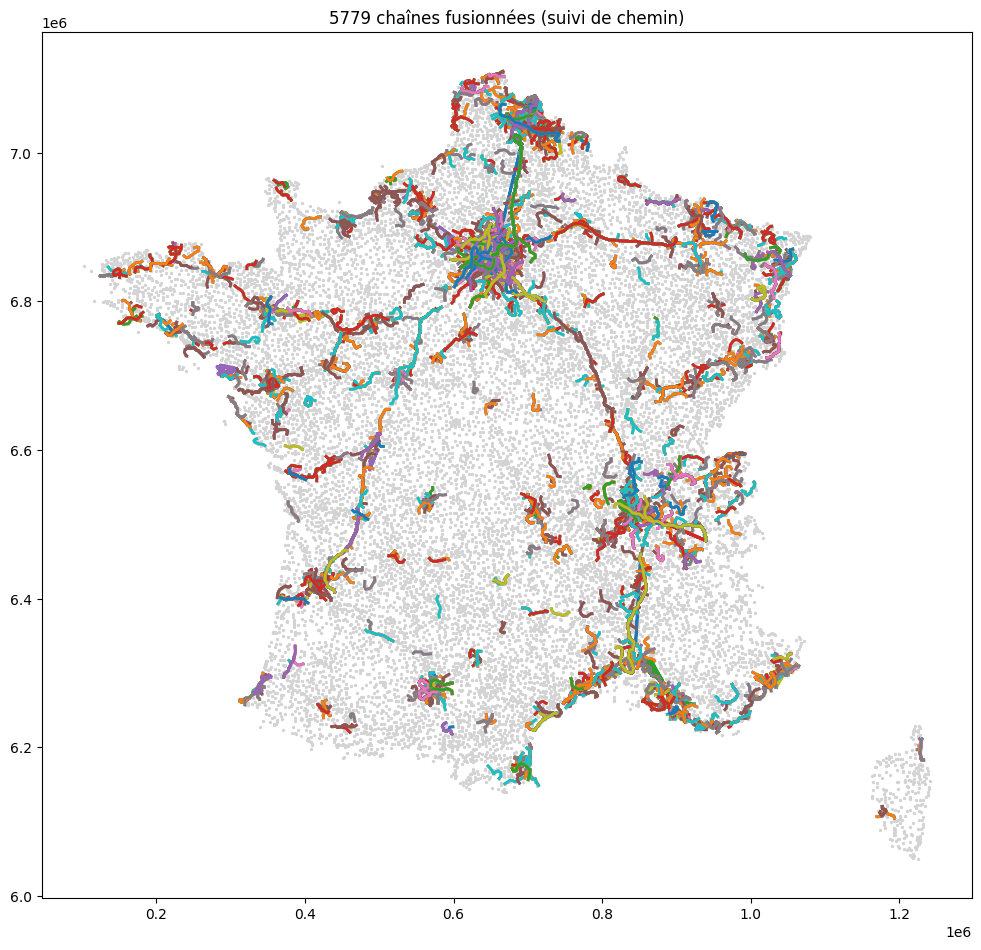

Longueur détectée : 365098.4 km
Longueur réelle (référence) : 432680.0 km
Erreur absolue : 67581.6 km
Erreur relative : 15.62%


(np.float64(67581.64975317265), np.float64(0.15619314447899751))

In [ ]:
# Paramètres pour la fusion
fusion_dist_thresh = 1000   # Distance max entre extrémités pour tenter une fusion
fusion_angle_thresh = 40    # Angle max entre les directions globales (degrés)


# Fusion
chains_fused = fuse_all_chains(chains, xy, fusion_angle_thresh, fusion_dist_thresh)
print(f"{len(chains)} → {len(chains_fused)} chaînes après fusion")

# Affichage
affichage_chains(xy, chains_fused, title = f"{len(chains_fused)} chaînes fusionnées (suivi de chemin)")

# Erreur
evaluate_chain_detection(xy, chains_fused)

### Par département



In [ ]:
# Données
df = pd.read_csv("data.csv", sep=";", decimal=',')
df = extract_data(df, provider="Orange") #, region='Normandie', techno="4G")

xy = df[['x', 'y']].to_numpy()
departements = df['nom_dep']

# -------------------------------
# Paramètres par département
params_by_dep = {
    'Alpes-Maritimes': {
        'k': 8,                       # nb voisins considérés
        'angle_tol_deg': 10,          # angle min entre directions de départ
        'n_directions': 3,            # nb directions de départ
        'dist_max': 3000,             # dist pour continuer la chaîne
        'angle_max': 30,              # angle pour continuer la chaîne (0 = plat)
        'min_len': 10,                 # nb de stations minimum pour garder la chaîne
        'fusion_dist': 700,           # distance max pour fusionner
        'fusion_angle': 25            # angle max pour fusionner
    },
    'Essone': {
        'k': 8,                       # nb voisins considérés
        'angle_tol_deg': 10,          # angle min entre directions de départ
        'n_directions': 3,            # nb directions de départ
        'dist_max': 500,              # dist pour continuer la chaîne
        'angle_max': 30,              # angle pour continuer la chaîne (0 = plat)
        'min_len': 10,                 # nb de stations minimum pour garder la chaîne
        'fusion_dist': 700,           # distance max pour fusionner
        'fusion_angle': 25            # angle max pour fusionner
    },
    'Gironde': {
        'k': 8,                       # nb voisins considérés
        'angle_tol_deg': 20,          # angle min entre directions de départ
        'n_directions': 3,            # nb directions de départ
        'dist_max': 2000,              # dist pour continuer la chaîne
        'angle_max': 20,              # angle pour continuer la chaîne (0 = plat)
        'min_len': 15,                 # nb de stations minimum pour garder la chaîne
        'fusion_dist': 700,           # distance max pour fusionner
        'fusion_angle': 25            # angle max pour fusionner
    },
    'Haute-Garonne': {
        'k': 8,                       # nb voisins considérés
        'angle_tol_deg': 20,          # angle min entre directions de départ
        'n_directions': 3,            # nb directions de départ
        'dist_max': 2000,              # dist pour continuer la chaîne
        'angle_max': 30,              # angle pour continuer la chaîne (0 = plat)
        'min_len': 10,                 # nb de stations minimum pour garder la chaîne
        'fusion_dist': 700,           # distance max pour fusionner
        'fusion_angle': 25            # angle max pour fusionner
    },
    'Nord': {
        'k': 8,                       # nb voisins considérés
        'angle_tol_deg': 10,          # angle min entre directions de départ
        'n_directions': 3,            # nb directions de départ
        'dist_max': 3000,             # dist pour continuer la chaîne
        'angle_max': 30,              # angle pour continuer la chaîne (0 = plat)
        'min_len': 10,                 # nb de stations minimum pour garder la chaîne
        'fusion_dist': 700,           # distance max pour fusionner
        'fusion_angle': 25            # angle max pour fusionner
    },
    'Paris': {
        'k': 8,                       # nb voisins considérés
        'angle_tol_deg': 20,          # angle min entre directions de départ
        'n_directions': 3,            # nb directions de départ
        'dist_max': 50,              # dist pour continuer la chaîne
        'angle_max': 20,              # angle pour continuer la chaîne (0 = plat)
        'min_len': 10,                 # nb de stations minimum pour garder la chaîne
        'fusion_dist': 700,           # distance max pour fusionner
        'fusion_angle': 25            # angle max pour fusionner
    },

    'Yvelines': {
        'k': 8,                       # nb voisins considérés
        'angle_tol_deg': 10,          # angle min entre directions de départ
        'n_directions': 3,            # nb directions de départ
        'dist_max': 3000,             # dist pour continuer la chaîne
        'angle_max': 30,              # angle pour continuer la chaîne (0 = plat)
        'min_len': 10,                 # nb de stations minimum pour garder la chaîne
        'fusion_dist': 700,           # distance max pour fusionner
        'fusion_angle': 25            # angle max pour fusionner
    },
    'default': {
        'k': 15,
        'angle_tol_deg': 2,
        'n_directions': 5,
        'dist_max': 4500,
        'angle_max': 80,
        'min_len': 9,
        'fusion_dist': 350,
        'fusion_angle': 25
    }
}
# -------------------------------

# Paramètres généraux
min_chain_len = 9  #10            # Longueur min pour considérer une "route"
fusion_dist_thresh = 1000   # Distance max entre extrémités pour fusionner
fusion_angle_thresh = 25    # Angle max entre les directions globales pour fusionner

/tmp/ipython-input-26-2197568103.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", sep=";", decimal=',')


In [ ]:
# Fonctions utilitaires

def direction(vec):
    norm = np.linalg.norm(vec)
    return vec / norm if norm != 0 else vec

### On considère les plus proches voisins, en filtrant légérement pour ne pas aller 2 fois dans la même direction
def find_best_directions(xy, idx, neighbors_idx, dist_max, angle_tol_deg, n_directions):
    """
    Params:
    - xy : array Nx2 des coordonnées des stations
    - idx : index de la station source
    - neighbors_idx : liste ou array des indices voisins à tester
    - dist_max : distance max entre stations pour considérer un lien
    - angle_tol_deg : tolérance angulaire minimale entre directions (en degrés)
    - n_directions : nombre max de directions à retourner
    """
    origin = xy[idx]
    directions = []
    used_angles = []

    for j in neighbors_idx:
        if j == idx:
            continue
        vec = xy[j] - origin
        dist = np.linalg.norm(vec)
        if dist == 0 or dist > dist_max:
            continue
        vec_unit = vec / dist
        angle = np.degrees(np.arctan2(vec_unit[1], vec_unit[0])) % 180  # angle dans [0,180)

        # Vérifier que cette direction est assez différente des directions déjà sélectionnées
        if all(abs((angle - a + 90) % 180 - 90) > angle_tol_deg for a in used_angles):
            directions.append(vec_unit)
            used_angles.append(angle)

        if len(directions) >= n_directions:
            break

    return directions


def follow_line(xy, idx_start, dir_vec, nn_model, dist_max, angle_max):
    path = [idx_start]
    current = idx_start
    while True:
        distances, indices = nn_model.kneighbors([xy[current]], return_distance=True)
        best = None
        best_angle = angle_max
        for dist, j in zip(distances[0][1:], indices[0][1:]):
            if j in path:
                continue
            vec = xy[j] - xy[current]
            if np.linalg.norm(vec) > dist_max:
                continue
            angle = angle_between(vec, dir_vec)
            if angle < best_angle:
                best_angle = angle
                best = j
        if best is None:
            break
        path.append(best)
        current = best
    return path

In [ ]:
# Application par département

all_chains = []

for dep, group in df.groupby('nom_dep'):
    print(f"Traitement du département {dep}...")
    indices = group.index.to_list()
    xy_dep = group[['x', 'y']].values

    p = params_by_dep.get(dep, params_by_dep['default'])

    nn_model = NearestNeighbors(n_neighbors=p['k']).fit(xy_dep)
    _, neighbors_idx = nn_model.kneighbors(xy_dep)

    chains = []
    for i in range(len(xy_dep)):
        directions = find_best_directions(xy_dep, i, neighbors_idx[i][1:], p['dist_max'], p['angle_tol_deg'], p['n_directions'])
        for dir_vec in directions:
            chain = follow_line(xy_dep, i, dir_vec, nn_model, p['dist_max'], p['angle_max'])
            if len(chain) >= p['min_len']:
                chains.append(chain)

    chains_fused = fuse_all_chains(xy_dep, chains, p['fusion_dist'], p['fusion_angle'])

    print(f"Nombre de chaînes : {len(chains)} -> {len(chains_fused)} (après fusion)")

    chains_global = [[indices[i] for i in chain] for chain in chains_fused]
    all_chains.extend(chains_global)

print(f"Nombre total de chaînes : {len(all_chains)}")

Traitement du département Ain...
Nombre de chaînes : 196 -> 191 (après fusion)
Traitement du département Aisne...
Nombre de chaînes : 33 -> 33 (après fusion)
Traitement du département Allier...
Nombre de chaînes : 6 -> 6 (après fusion)
Traitement du département Alpes-Maritimes...
Nombre de chaînes : 48 -> 47 (après fusion)
Traitement du département Alpes-de-Haute-Provence...
Nombre de chaînes : 0 -> 0 (après fusion)
Traitement du département Ardennes...
Nombre de chaînes : 33 -> 33 (après fusion)
Traitement du département Ardèche...
Nombre de chaînes : 14 -> 14 (après fusion)
Traitement du département Ariège...
Nombre de chaînes : 11 -> 11 (après fusion)
Traitement du département Aube...
Nombre de chaînes : 17 -> 17 (après fusion)
Traitement du département Aude...
Nombre de chaînes : 22 -> 22 (après fusion)
Traitement du département Aveyron...
Nombre de chaînes : 9 -> 9 (après fusion)
Traitement du département Bas-Rhin...
Nombre de chaînes : 743 -> 655 (après fusion)
Traitement du dépa

In [ ]:
# Fusion
# index_to_pos = {idx: pos for pos, idx in enumerate(df.index)}
# chains_by_position = [
#     [index_to_pos[i] for i in chain]
#     for chain in all_chains
# ]
# all_chains_fused = fuse_all_chains(xy, chains_by_position, fusion_dist_thresh, fusion_angle_thresh)

# print(f"Nombre total de chaînes après fusion : {len(all_chains_fused)}")

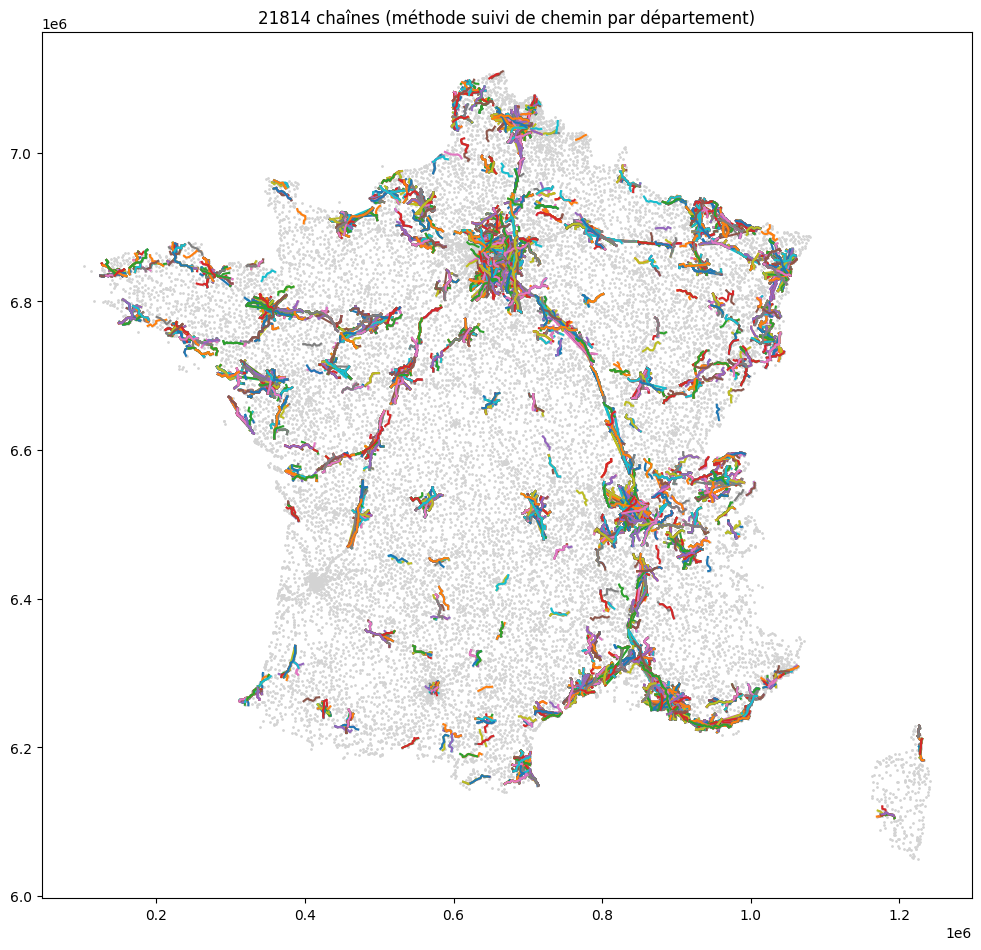

In [ ]:
# Affichage
affichage_chains(xy, all_chains, title = f"{len(all_chains)} routes détectées (paramètres par département)")

### Selon densité de stations

In [ ]:
# Données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider="Orange") #, techno="4G") #, region='Normandie', techno="4G")

xy = df[['x', 'y']].to_numpy()
departements = df['nom_dep']

pts_hors_ville, masque_hors_ville = points_hors_ville(xy, 10, 2500) # Pour tout opérateur : 5, 1000) # Pour Orange seul : 10, 2500)

/tmp/ipython-input-3484992221.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


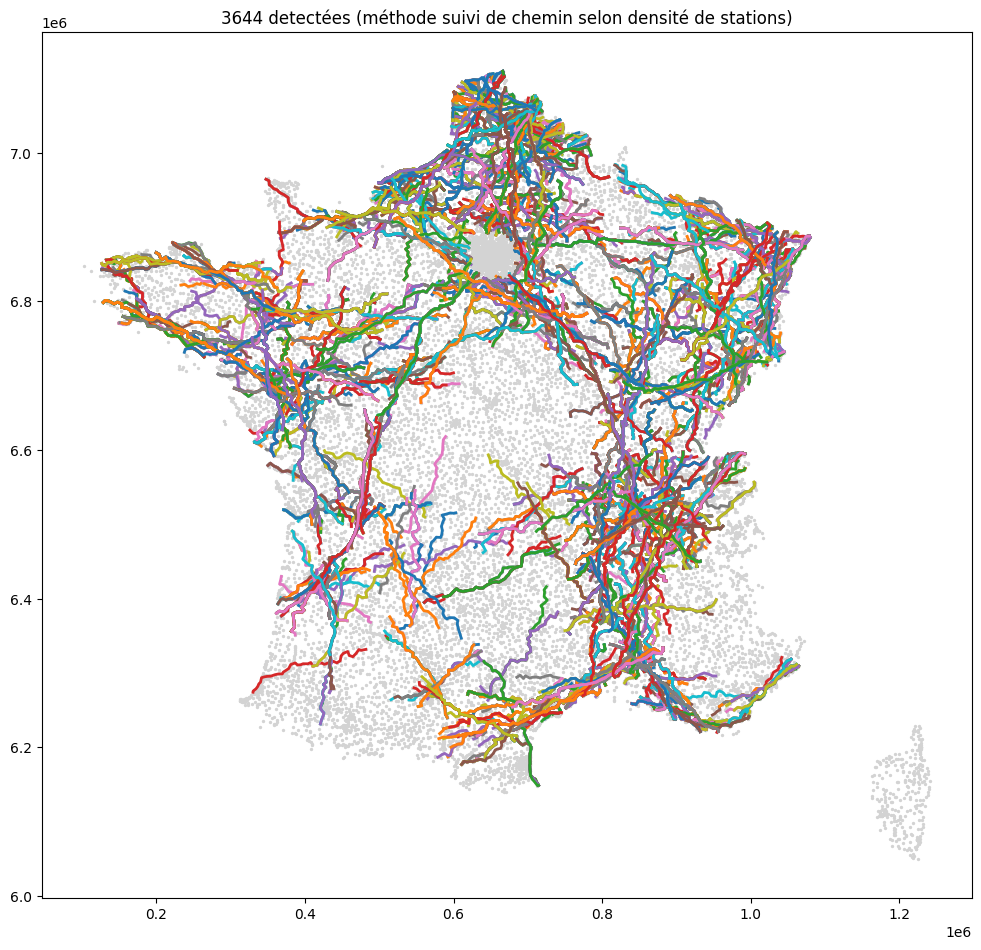

🔹 Nombre de chaînes trouvées :  3644
🔹 Longueur moyenne des chaînes : 203.207 km
🔹 Écart-type longueur des chaînes : 54.703 km
🔹 Longueur moyenne des chaînes : 50.7 stations
🔹 Écart-type longueur des chaînes : 10.85

🔹 Évaluation globale :
Longueur détectée : 740486.3 km
Longueur réelle (référence) : 432680.0 km
Erreur absolue : 307806.3 km
Erreur relative : 71.14%

🔹 Évaluation par département :
   Département  Réel (km)  Détecté (km)  Erreur (km) Erreur relative (%)
90     Ardèche        238       17290.5      17052.5             7164.9%
15     Hérault        464       19782.6      19318.6             4163.5%
54   Haut-Rhin        261       10933.1      10672.1             4088.9%
19       Somme        719       27989.7      27270.7             3792.9%
43       Isère        758       27973.1      27215.1             3590.4%

Écart-type des erreurs départementales : 12.859
Max erreur relative d’un département : 7164.91%
Nombre de départements à forte erreur (>50%) : 86
Départements no

In [ ]:
# -------------------------------
# Paramètres

n_neighbors = 15
r_density = 35000  #30000
n_directions = 4 #5
angle_tol = 5
dist_min = 1
dist_max = 7000 #5000
angle_min = 25
angle_max = 85
min_len = 40


# Application
chains = detect_chains_by_density(xy, r_density, n_neighbors, dist_min, dist_max, angle_min, angle_max, angle_tol, n_directions, min_len)

# Affichage
affichage_chains(xy, chains, title = f"{len(chains)} detectées (méthode suivi de chemin selon densité de stations)")

ref_total_length = (
    df_routes['Autoroutes'].sum() +
    df_routes['Routes nationales'].sum() +
    # df_routes['Routes départementales et voies communales'].sum() +
     382491 +    # Routes départementales, d'après statista
    # 714,883 +  # Routes communales, d'après statista
    df_chemin_fer['long_ferre'].sum()
)
#ref_total_length = 980 + 342  # Autoroutes + Nationales centre val de loire, d'après l'observatoire des territoires   #df_routes['Autoroutes'].sum() + df_routes['Routes nationales'].sum() + df_chemin_fer['long_ferre'].sum()

df_metrics = compute_chain_metrics(xy, chains, departements, ref_total_length)

# Erreur
# evaluate_chain_detection(xy, chains, departements, ref_total_length)

# df_eval = evaluate_by_department(xy, chains, df['nom_dep'])
# print(df_eval.head(10))  # top 10 pires départements

# # Barplot
# df_eval_sorted = df_eval.sort_values(by="Erreur relative", ascending=False)

# plt.figure(figsize=(16, 6))
# plt.bar(df_eval_sorted["Département"], df_eval_sorted["Erreur (km)"])
# plt.xticks(rotation=90)
# plt.title("Erreur absolue par département (km)")
# plt.tight_layout()
# plt.show()

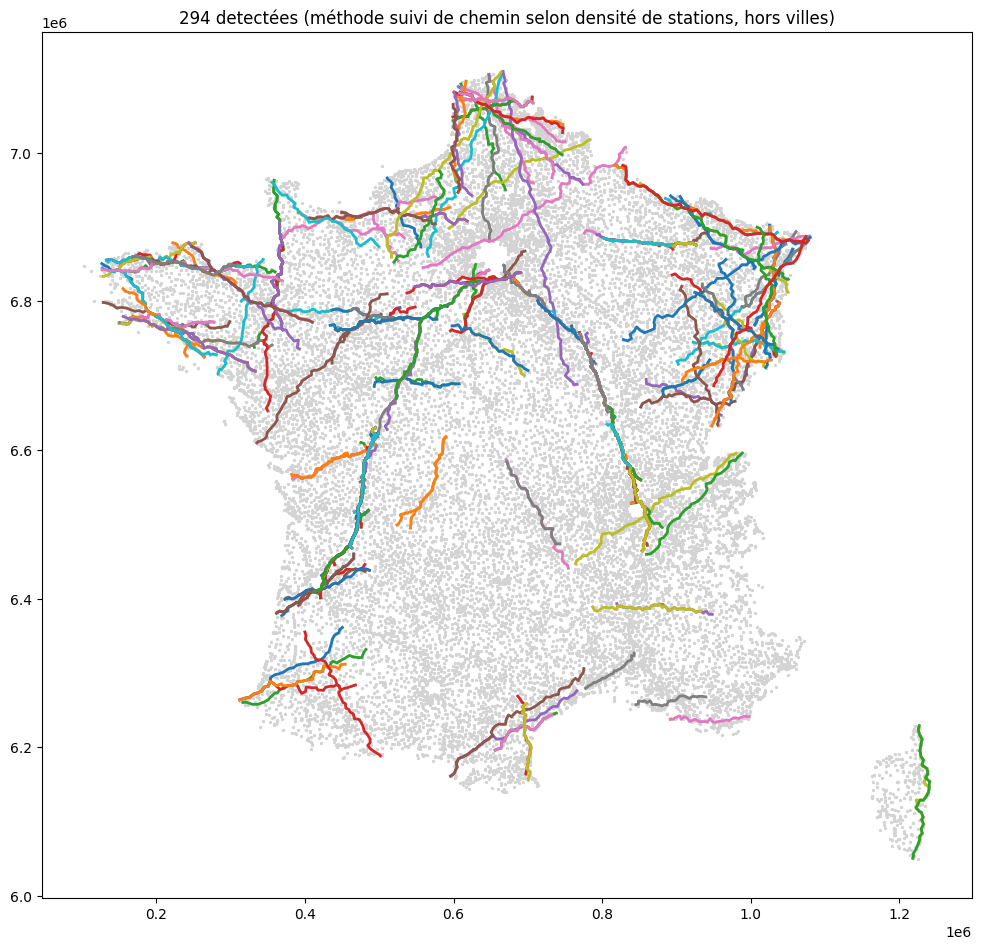

Évaluation globale :
Longueur détectée : 46123.9 km
Longueur réelle (référence) : 50189.0 km
Erreur absolue : 4065.1 km
Erreur relative : 8.10%

Évaluation par département :
        Département  Réel (km)  Détecté (km)  Erreur (km)  Erreur relative  \
57            Paris         73        1349.4       1276.4        17.484925   
58     Corse-du-Sud         51         211.7        160.7         3.151365   
4    Hauts-de-Seine        155         583.0        428.0         2.761201   
89  Alpes-Maritimes        252         887.0        635.0         2.519971   
67              Var        355         974.5        619.5         1.745155   

   Erreur relative (%)  
57             1748.5%  
58              315.1%  
4               276.1%  
89              252.0%  
67              174.5%  
🔹 Écart-type des erreurs départementales : 1.801
🔹 Max erreur relative d’un département : 1748.49%
🔹 Nombre de départements à forte erreur (>50%) : 28
🔹 Taux de redondance (chaînes quasi-identiques, >90%) : 

In [ ]:
# -------------------------------
# Application hors villes

# Paramètres
n_neighbors = 10
r_density = 38000  #20000
dist_min =  1
dist_max = 8500 #5000
angle_min = 65
angle_max = 85
n_directions = 3 #5
angle_tol = 5
# angle_tol_min = 8
# angle_tol_max = 25
min_len = 30


chains_hors_ville = detect_chains_by_density(pts_hors_ville, r_density, n_neighbors, dist_min, dist_max, angle_min, angle_max, angle_tol, n_directions, min_len)

# Affichage
affichage_chains(pts_hors_ville, chains_hors_ville, title = f"{len(chains_hors_ville)} detectées (méthode suivi de chemin selon densité de stations, hors villes)")

ref_total_length = (
    df_routes['Autoroutes'].sum() +
    df_routes['Routes nationales'].sum() +
    # df_routes['Routes départementales et voies communales'].sum() +
    # 382491 +    # Routes départementales, d'après statista
    # 714,883 +  # Routes communales, d'après statista
    df_chemin_fer['long_ferre'].sum()
)

df_metrics = compute_chain_metrics(pts_hors_ville, chains_hors_ville, departements, ref_total_length)

# # Barplot
# df_eval_sorted = df_eval.sort_values(by="Erreur relative", ascending=False

# # Erreur
# evaluate_chain_detection(xy, chains_hors_ville, departements, ref_total_length)

# df_eval = evaluate_by_department(xy, chains_hors_ville, df['nom_dep'])
# print(df_eval.head(10))  # top 10 pires départements

In [ ]:
# Fusion hors ville
fusion_dist = 500
fusion_angle = 90

chains_fused = fuse_all_chains(pts_hors_ville, chains_hors_ville, fusion_dist, fusion_angle)

print(f"Nombre de chaînes : {len(chains_hors_ville)} -> {len(chains_fused)} (après fusion)")

# Affichage
affichage_chains(pts_hors_ville, chains_fused, title = f"{len(chains_fused)} chaînes fusionnées (suivi de chemin par densité de stations)")

# Erreur
evaluate_chain_detection(xy, chains_fused)

TypeError: list indices must be integers or slices, not numpy.float64

Nombre de chaînes : 4318 -> 4148 (après fusion)


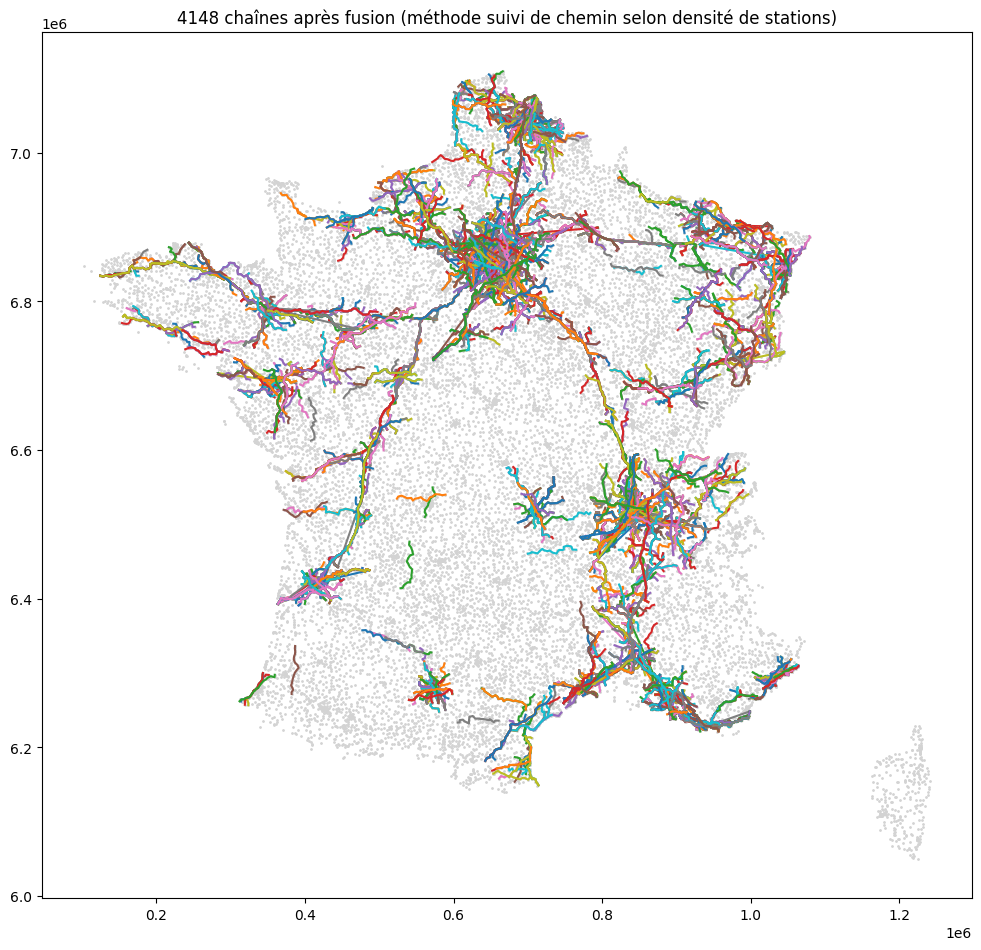

In [ ]:
# Fusion avec villes
fusion_dist = 500
fusion_angle = 90

chains_fused = fuse_all_chains(xy, chains, fusion_dist, fusion_angle)

print(f"Nombre de chaînes : {len(chains)} -> {len(chains_fused)} (après fusion)")

# Affichage
affichage_chains(xy, chains_fused, title = f"{len(chains_fused)} chaînes fusionnées (suivi de chemin par densité de stations)")

# Erreur
evaluate_chain_detection(xy, chains_fused)

#### Déterminer meilleur rayon

In [ ]:
# Paramètres

n_neighbors = 10
dist_min = 5
dist_max = 7000 #5500
angle_min = 20
angle_max = 90
n_directions = 5 #5
angle_tol = 5
min_len = 20


rayons = np.linspace(80000, 120000, 9)
erreurs = []
rel_erreurs = []

for r in rayons:
    chains = detect_chains_by_density(xy, r, n_neighbors, dist_min, dist_max, angle_min, angle_max, angle_tol, n_directions, min_len)
    affichage_chains(xy, chains, title = f"{len(chains)} detectées avec r = {r}")
    err, rel_err = evaluate_chain_detection(xy, chains)
    erreurs.append(err)
    rel_erreurs.append(rel_err)

plt.plot(rayons, erreurs)
plt.xlabel("Rayon")
plt.ylabel("Erreur absolue")
plt.title("Erreur absolue selon le rayon choisi pour la détection par densité")
plt.show()

plt.plot(rayons, rel_erreurs)
plt.xlabel("Rayon")
plt.ylabel("Erreur relative")
plt.title("Erreur relative selon le rayon choisi pour la détection par densité")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Détection des meilleurs paramètres

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider="Orange") #, techno="4G") #, region='Normandie')

xy = df[['x', 'y']].to_numpy()
departements = df['nom_dep']

#xy, _ = points_hors_ville(xy, 10, 2500)   ### Pour enlever les points en ville

ref_total_length = (
    df_routes['Autoroutes'].sum() +
    df_routes['Routes nationales'].sum() +
    # df_routes['Routes départementales et voies communales'].sum() +
    382491 +    # Routes départementales, d'après statista
    # 714,883 +  # Routes communales, d'après statista
    df_chemin_fer['long_ferre'].sum()
)

# === Définir l’espace des paramètres ===
space = [
    Categorical(list(range(16000, 46000, 2000)), name='rayon'),     # Entier entre 20000 et 60000 avec un pas de 2000
    Categorical(list(range(10, 20, 5)), name='n_neighbors'),
    Integer(3, 5, name='n_directions'),
    Categorical(list(range(0, 5, 5)), name='angle_tol'),
    Categorical(list(range(1, 400, 10)), name='dist_min'),
    #Integer(10, 200, name='dist_min'),
    Categorical(list(range(6000, 8000, 500)), name='dist_max'),
    Categorical(list(range(15, 80, 5)), name='angle_min'),
    Categorical(list(range(70, 90, 5)), name='angle_max'),
    Categorical(list(range(20, 45, 5)), name='min_len'),
    # Paramètre du calcul des paramètres en fonction de la densité
    # Integer(1, 2, name='factor')                                                               # Pour rien (pas d'influence)
    # Integer(1, 20, name='factor')                                                              # Pour sigmoid
    Integer(5, 50, name='factor')                                                            # Pour log
    # Real(1, 2, prior='log-uniform', name='factor')  # privilégie les petites valeurs          # Pour power
]

@use_named_args(space)
def objective(rayon, n_neighbors, dist_min, dist_max, angle_min, angle_max, n_directions, angle_tol, min_len, factor):
    # Vérification simple de cohérence
    if dist_min >= dist_max or angle_min >= angle_max:
        return 1e7  # très mauvaise erreur → rejeté

    # Détection des routes
    print(f"\nTest avec : rayon={rayon:.0f}, n_neighbors={n_neighbors}, n_dir={n_directions}, angle_tol={angle_tol}, dist_min={dist_min}, dist_max={dist_max}, angle_min={angle_min}, angle_max={angle_max}, min_len={min_len}, factor={factor}.")
    chains = detect_chains_by_density(xy, rayon, n_neighbors, dist_min, dist_max, angle_min, angle_max, angle_tol, n_directions, min_len, factor)
    affichage_chains(xy, chains, title = f"{len(chains)} detectées")

    # Évaluation
    score = evaluate_chain_detection(xy, chains, departements, ref_total_length, alpha=0.97, beta=0.03)  # alpha = poids d'erreur globale, beta = poids d'écart type d'erreurs des départements

    return score  # à minimiser

# === Optimisation ===
res = gp_minimize(
    func = objective,
    dimensions = space,
    n_calls = 18,            # Ajuster selon le budget temps (~15 min × n_calls)
    n_initial_points = 8,    # nombre de tests aléatoires au départ, pour voir ensuite où chercher dans l'espace
    random_state = 43,
    verbose = True
)

# === Résultats ===
best_params = dict(zip([dim.name for dim in space], res.x))
print("\n Meilleurs paramètres trouvés :")
for k, v in best_params.items():
    print(f"  - {k} = {v}")
print(f"Erreur minimale : {res.fun}")

# res.x      # Meilleurs paramètres trouvés
# res.fun    # Meilleure valeur de la fonction (donc erreur minimale)
# res.x_iters  # Tous les paramètres testés
# res.func_vals  # Toutes les erreurs associées

Output hidden; open in https://colab.research.google.com to view.

### Selon densité de routes par département


In [ ]:
# -------------------------------
# Données d'entrée
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider="Orange") #, region='Normandie', techno="4G")

xy = df[['x', 'y']].to_numpy()
departements = df['nom_dep']

/tmp/ipython-input-4215925439.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


In [ ]:
def compute_params_from_density(density, min_dens, max_dens, dist_min, dist_max):  # dist_range=(500, 1500), angle_range=(15, 40), n_dir_range=(2, 6)):
    """
    Convertit une densité en paramètres à appliquer pour la détection de chaînes.
    On suppose que plus la densité est forte, plus les routes sont proches et nombreuses.
    """
    # Normalisation dans [0,1]
    d = np.clip((density - min_dens) / (max_dens - min_dens), 0, 1)

    dist_param = dist_max - d * (dist_max - dist_min)
    # angle_max = angle_range[0] + d * (angle_range[1] - angle_range[0])
    # n_directions = int(n_dir_range[0] + d * (n_dir_range[1] - n_dir_range[0]))

    return dist_param # {"dist_param": dist_param, "angle_max": angle_max, "n_directions": n_directions, }

In [ ]:
# Paramètres

n_neighbors = 15
n_directions = 3
angle_tol = 5
dist_min = 1
dist_max = 5500

# angle_min = 0
# angle_max = 90
angle_max = 80

min_len = 9

fusion_dist = 500
fusion_angle = 80

In [ ]:
# Calcul de la densité de routes par département

df_routes = pd.read_csv("database/data_len_routes.csv", sep=",", decimal='.')
df_chemin_fer = pd.read_csv("database/data_len_train.csv", sep=";", decimal=',')
df_dep = pd.read_csv("database/data_popArea.csv", sep=";", decimal=',')

route_density = {}
for dep in departements:
    road_row = df_routes[df_routes['nom_dep'] == dep]
    rail_row = df_chemin_fer[df_chemin_fer['libgeo'] == dep]
    area_row = df_dep[df_dep['nom_dep'] == dep]

    road_len = road_row['Autoroutes'].sum() + road_row['Routes nationales'].sum()
    rail_len = rail_row['long_ferre'].sum()
    area = area_row['Superficie [en km²]'].sum()

    if area == 0:  # éviter division par 0
        area = 1

    route_density[dep] = (road_len + rail_len) / area


In [ ]:
densities = list(route_density.values())
min_dens = min(densities)
max_dens = max(densities)

print(f"Densité minimale : {min_dens}")
print(f"Densité maximale : {max_dens}")


Densité minimale : 0.012705530642750373
Densité maximale : 0.8806818181818182


In [ ]:
# -------------------------------
# Application par département

all_chains = []

for dep, group in df.groupby('nom_dep'):
    print(f"Traitement du département {dep}...")
    indices = group.index.to_numpy()
    xy_dep = group[['x', 'y']].values

    dist_param = compute_params_from_density(route_density[dep], min_dens, max_dens, dist_min, dist_max)

    nn_model = NearestNeighbors(n_neighbors=n_neighbors).fit(xy_dep)
    _, neighbors_idx = nn_model.kneighbors(xy_dep)

    chains = []
    for i in range(len(xy_dep)):
        directions = find_best_directions(xy_dep, i, neighbors_idx[i][1:], dist_param, angle_tol, n_directions)
        for dir_vec in directions:
            chain = follow_line(xy_dep, i, dir_vec, nn_model, dist_param, angle_max)
            if len(chain) >= min_len:
                chains.append(chain)

#    chains_fused = fuse_all_chains(xy_dep, chains, fusion_dist, fusion_angle)
#chains_global = [[group.index[i] for i in chain] for chain in chains_fused]
    print(f"Nombre de chaînes : {len(chains)}") # -> {len(chains_fused)} (après fusion)")

    chains_global = [[group.index[i] for i in chain] for chain in chains]   # chains_fused]
    all_chains.extend(chains_global)

print(f"Nombre total de chaînes : {len(all_chains)}")

Traitement du département Ain...
Nombre de chaînes : 175
Traitement du département Aisne...
Nombre de chaînes : 34
Traitement du département Allier...
Nombre de chaînes : 7
Traitement du département Alpes-Maritimes...
Nombre de chaînes : 832
Traitement du département Alpes-de-Haute-Provence...
Nombre de chaînes : 2
Traitement du département Ardennes...
Nombre de chaînes : 37
Traitement du département Ardèche...
Nombre de chaînes : 113
Traitement du département Ariège...
Nombre de chaînes : 39
Traitement du département Aube...
Nombre de chaînes : 47
Traitement du département Aude...
Nombre de chaînes : 113
Traitement du département Aveyron...
Nombre de chaînes : 7
Traitement du département Bas-Rhin...
Nombre de chaînes : 551
Traitement du département Bouches-du-Rhône...
Nombre de chaînes : 1149
Traitement du département Calvados...
Nombre de chaînes : 311
Traitement du département Cantal...
Nombre de chaînes : 7
Traitement du département Charente...
Nombre de chaînes : 130
Traitement du

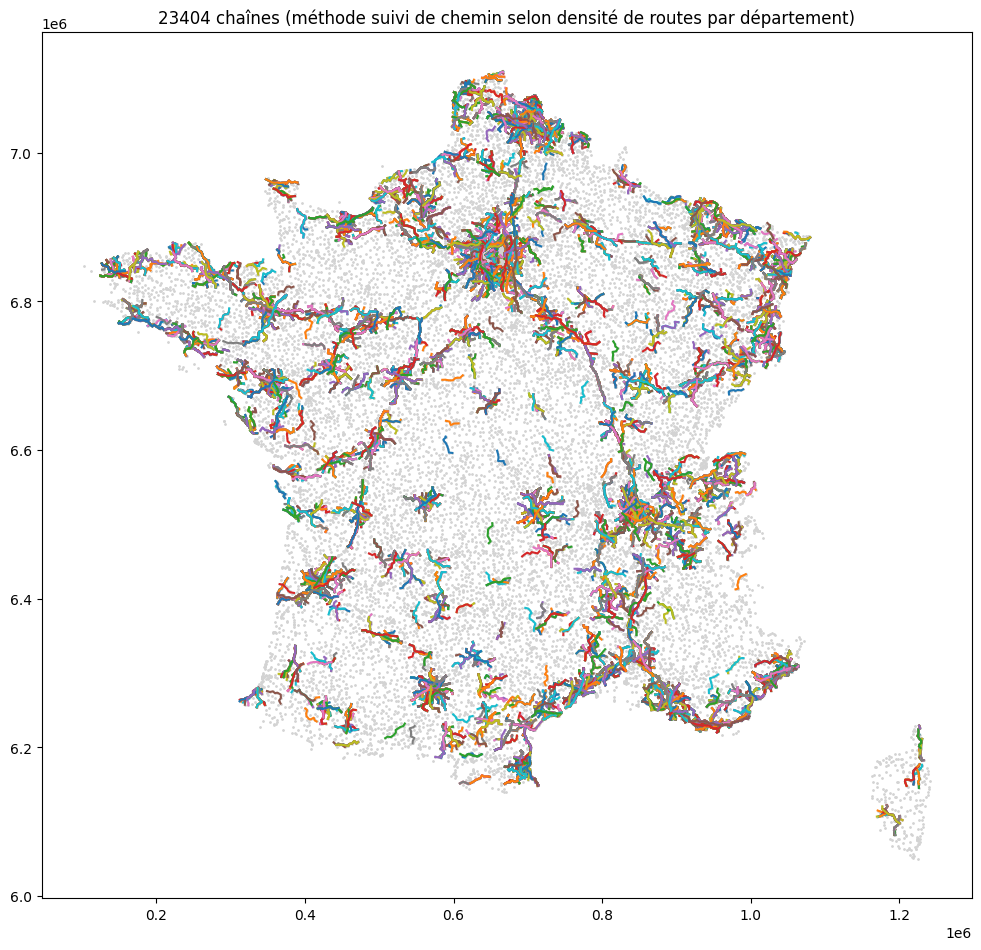

🔹 Nombre de chaînes trouvées :  530
🔹 Longueur moyenne des chaînes : 5609.380 km
🔹 Écart-type longueur des chaînes : 1944.155 km
🔹 Longueur moyenne des chaînes : 14.1 stations
🔹 Écart-type longueur des chaînes : 4.02

🔹 Évaluation globale :
Longueur détectée : 2972971.3 km
Longueur réelle (référence) : 432680.0 km
Erreur absolue : 2540291.3 km
Erreur relative : 587.11%

🔹 Évaluation par département :
        Département  Réel (km)  Détecté (km)  Erreur (km) Erreur relative (%)
9             Paris         73      134916.3     134843.3           184716.9%
12     Corse-du-Sud         51       46820.5      46769.5            91704.8%
56  Alpes-Maritimes        252      139684.0     139432.0            55330.2%
25      Haute-Corse        181       74337.3      74156.3            40970.3%
71     Val-de-Marne        183       48100.5      47917.5            26184.4%

Écart-type des erreurs départementales : 216.494
Max erreur relative d’un département : 184716.87%
Nombre de départements à for

In [ ]:
# -------------------------------
# Affichage
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(xy[:, 0], xy[:, 1], s=1, color='lightgray')
for chain in all_chains:
    coords = df.loc[chain, ['x', 'y']].values
    ax.plot(coords[:, 0], coords[:, 1], '-', lw=1.5)
ax.set_title(f"{len(all_chains)} chaînes (méthode suivi de chemin selon densité de routes par département)")
ax.set_aspect('equal')
plt.show()

# Erreur
# global_chains = to_global_chains(all_chains, indices)  # Transformation pour avoir les indices corrects

# Convertir les index globaux (quel que soit leur type) en positions numériques dans xy
idx_map = {idx: pos for pos, idx in enumerate(df.index)}
all_chains = [[idx_map[i] for i in chain] for chain in all_chains]

# evaluate_chain_detection(xy, all_chains)
df_metrics = compute_chain_metrics(xy, chains, departements, ref_total_length)

## Détection en 2 étapes

/tmp/ipython-input-2645117513.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


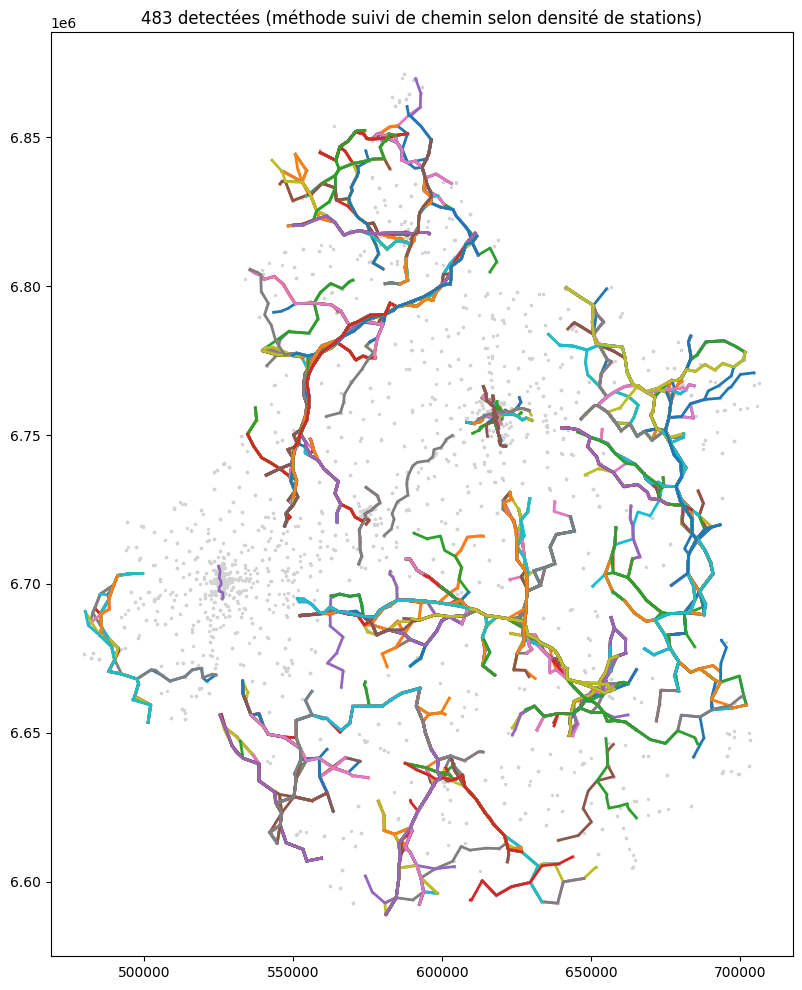

In [ ]:
# --------------------------- Centre-Val de Loire --------
# Données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, region = "Centre-Val de Loire") #, provider="Orange") #, techno="4G") #, region='Normandie', techno="4G")

xy = df[['x', 'y']].to_numpy()
departements = df['nom_dep']

# pts_hors_ville, masque_hors_ville = points_hors_ville(xy, 10, 2500) # Pour tout opérateur : 5, 1000) # Pour Orange seul : 10, 2500)

# -------------------------------
# Paramètres

n_neighbors = 15
r_density = 30000  #30000
n_directions = 4 #5
angle_tol = 0
dist_min = 800
dist_max =8000 #5000
angle_min = 75
angle_max = 85
min_len = 20


# Application
chains_centre = detect_chains_by_density(xy, r_density, n_neighbors, dist_min, dist_max, angle_min, angle_max, angle_tol, n_directions, min_len)

# Affichage
affichage_chains(xy, chains_centre, title = f"{len(chains)} detectées (méthode suivi de chemin selon densité de stations)")

ref_total_length = 980 + 342  # Autoroutes + Nationales centre val de loire, d'après l'observatoire des territoires   #df_routes['Autoroutes'].sum() + df_routes['Routes nationales'].sum() + df_chemin_fer['long_ferre'].sum()

# df_metrics = compute_chain_metrics(xy, chains_centre, departements, ref_total_length)

In [ ]:
# ------------------------------- France --------
# Données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider="Orange") #, techno="4G") #, region='Normandie', techno="4G")

xy = df[['x', 'y']].to_numpy()
departements = df['nom_dep']

# pts_hors_ville, masque_hors_ville = points_hors_ville(xy, 10, 2500) # Pour tout opérateur : 5, 1000) # Pour Orange seul : 10, 2500)


# Paramètres

n_neighbors = 15
r_density = 16000  #30000
n_directions = 5 #5
angle_tol = 5
dist_min = 50
dist_max = 7000 #5000
angle_min = 50
angle_max = 85
min_len = 20


# Application
chains_fr = detect_chains_by_density(xy, r_density, n_neighbors, dist_min, dist_max, angle_min, angle_max, angle_tol, n_directions, min_len)

# Affichage
affichage_chains(xy, chains_fr, title = f"{len(chains)} detectées (méthode suivi de chemin selon densité de stations)")

ref_total_length = (
    df_routes['Autoroutes'].sum() +
    df_routes['Routes nationales'].sum() +
    # df_routes['Routes départementales et voies communales'].sum() +
    # 382491 +    # Routes départementales, d'après statista
    # 714,883 +  # Routes communales, d'après statista
    df_chemin_fer['long_ferre'].sum()
)


chains = np.concatenate((chains_centre, chains_fr))
affichage_chains(xy, chains, title = f"{len(chains)} detectées (méthode suivi de chemin selon densité de stations)")

df_metrics = compute_chain_metrics(xy, chains, departements, ref_total_length)

/tmp/ipython-input-1079233069.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


KeyboardInterrupt: 